In [55]:
import pandas as pd
from tqdm import tqdm
import os
import re
from math import sqrt
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from IPython.display import display, Markdown

# Wrangle

[Hypothesis Testing](#hypothesis)

In [2]:
def load_csv_file(filename):
    try:
        if not os.path.exists(filename):
            print(f"The file: {filename} doesn't exist")
        else:
            print("Found File")
            return pd.concat([chunk for chunk in tqdm(pd.read_csv(filename, chunksize=1000), desc=f'Loading {filename}')])
    except:
        print("Didn't Work! :(")

In [3]:
def rename_columns(df):
    new_names = []

    for column in df.columns:
        level_one = re.sub('(?<!^)(?=[A-Z])', '_', column).lower()
        level_one = re.sub(' ', '_',level_one)
        level_one = re.sub(' _', '_',level_one)
        level_one = re.sub('__','_',level_one)
        new_names.append(level_one)
    df.columns = new_names
    return df

In [4]:
def data_dictionary(df):
    # Printing a data dictionary using a printout of each column name
    # formatted as a MarkDown table
    # =================================================================

    # variable to hold size of longest string in dataframe column names
    size_longest_name = len((max((df.columns.to_list()), key = len)))

    # head of markdown table
    print(f"| {'Name' : <{size_longest_name}} | Definition |")
    print(f"| {'-'*size_longest_name} | {'-'*len('Definition')} |")

    # dataframe column content
    for i in (df.columns.to_list()):
        print(f"| {i : <{size_longest_name}} | Definition |")

In [5]:
def plot_clust(df):
    num, cat = separate_column_type_list(df)
    train_scaled = df[num]
    # Create Object
    mm_scaler = MinMaxScaler()
    train_scaled[num] = mm_scaler.fit_transform(train_scaled[num])
    seed = 42
    cluster_count = 4

    kmeans = KMeans(n_clusters=cluster_count,random_state=seed)
    kmeans.fit(train_scaled)
    df['clusters']=kmeans.predict(train_scaled)
    sns.boxplot(data=df,x='clusters',y='alcohol',hue='quality')
    plt.title("What about Clustering?")
    plt.show()

In [ ]:
def split_data(df, target):
    '''
    This function take in a dataframe performs a train, validate, test split
    Returns train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test
    and prints out the shape of train, validate, test
    '''
    
    #create train_validate and test datasets
    train, test = train_test_split(df, train_size = 0.8, random_state = 123)
    #create train and validate datasets
    train, validate = train_test_split(train, train_size = 0.7, random_state = 123)

    #Split into X and y
    X_train = train.drop(columns=[target])
    y_train = train[target]

    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]

    X_test = test.drop(columns=[target])
    y_test = test[target]

    # Have function print datasets shape
    print(f'train -> {train.shape}')
    print(f'validate -> {validate.shape}')
    print(f'test -> {test.shape}')
   
    return train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test

In [6]:
def get_dum1(df):   
    # Create dummies for non-binart categorical variables
    to_dummy = ['wine_color']
    dummies = pd.get_dummies(df[to_dummy], drop_first=False)
    df = pd.concat([df, dummies], axis=1)
    
    # drop redundant column
    drop = ['wine_color']
    df.drop(columns=drop, inplace=True)
    
    return df

In [72]:
def eval_results_2(p, alpha, group1, group2):
    '''
        Test Hypothesis  using Statistics Test Output.
        This function will take in the p-value, alpha, and a name for the 2 variables
        you are comparing (group1 and group2) and return a string stating 
        whether or not there exists a relationship between the 2 groups. 
    '''
    if p < alpha:
        display(Markdown(f"### Results:"))
        display(Markdown(f"### Reject $H_0$"))
        display(Markdown( f'There exists some relationship between {group1} and {group2}. (p-value: {p:.4f})'))
    
    else:
        display(Markdown(f"### Results:"))
        display(Markdown(f"### Failed to Reject $H_0$"))
        display(Markdown( f'There is not a significant relationship between {group1} and {group2}. (p-value: {p:.4f})'))

[Hypothesis Testing](#hypothesis) <a id="functions"></a>

In [74]:
def question_hypothesis_test_2(question_number,df,feature,target,alpha=.05):
    question = f"Does a higher {feature} mean higher {target}?"
    
    # calculations
    r, p = stats.pearsonr(df[feature], df[target])
    value = r
    p_value = p
        
    # Output variables
    test = "Pearson's R"

    # Markdown Format Metrics
    display(Markdown(f"# Question #{question_number}:"))
    display(Markdown(f"# {question}"))
    display(Markdown(f"### Hypothesis:"))
    display(Markdown(f"$H_0$: There is no relationship between `{feature}` to `{target}`"))
    display(Markdown(f"$H_A$: There is a relationship between `{feature}` and `{target}` "))
    display(Markdown(f"### Statistics Test:"))
    display(Markdown(f"### `{test} = {value}`"))
    
    # Evaluate Results
    eval_results_2(p_value, alpha, feature, target)

In [64]:
def question_hypothesis_test(question_number,df,column_name,question,target,alpha=.05):
    num, cat = separate_column_type_list(df)

    if (target in cat) and (column_name in num):
        # calculation
        overall_alcohol_mean = df[column_name].mean()
        quality_sample = df[df[target] >= 7][target]
        t, p = stats.ttest_1samp(quality_sample, overall_alcohol_mean)
        value = t
        p_value = p/2
        
        # Output variables
        test = "1-Sample T-Test"

        # Markdown Formatting
        display(Markdown(f"# Question #{question_number}:"))
        display(Markdown(f"# {question}"))
        display(Markdown(f"### Hypothesis:"))
        display(Markdown(f"$H_0$: There is no relationship between `{column_name}` and `{target}`"))
        display(Markdown(f"$H_A$: There is a relationship between `{column_name}` and `{target}` "))
        display(Markdown(f"### Statistics Test:"))
        display(Markdown(f"### `{test} = {value}`"))

        eval_results_2(p_value, alpha, column_name, target)

    elif (target in cat) and (column_name in cat):
        # calculations
        observed = pd.crosstab(df[column_name], df[target])
        chi2, p, degf, expected = stats.chi2_contingency(observed)
        value = chi2
        p_value = p
        
        # Output variables
        test = "Chi-Square"

        # Markdown Formatting
        display(Markdown(f"# Question #{question_number}:"))
        display(Markdown(f"# {question}"))
        display(Markdown(f"### Hypothesis:"))
        display(Markdown(f"$H_0$: There is no relationship between `{column_name}` to `{target}`"))
        display(Markdown(f"$H_A$: There is a relationship between `{column_name}` and `{target}` "))
        display(Markdown(f"### Statistics Test:"))
        display(Markdown(f"### `{test} = {value}`"))

        eval_results_2(p_value, alpha, column_name, target)

    elif (target in num) and (column_name in num):
        print("num on num")
        # calculations
        ##r, p = stats.pearsonr(df[column_name], df[target])
        ##value = r
        ##p_value = p

        # Output variables
        ##test = "Pearson's R"

        # Markdown Formatting
        ##display(Markdown(f"# Question #{question_number}:"))
        ##display(Markdown(f"# {question}"))
        ##display(Markdown(f"### Hypothesis:"))
        ##display(Markdown(f"$H_0$: There is no relationship between `{column_name}` to `{target}`"))
        ##display(Markdown(f"$H_A$: There is a relationship between `{column_name}` and `{target}` "))
        ##display(Markdown(f"### Statistics Test:"))
        ##display(Markdown(f"### `{test} = {value}`"))

        ##eval_results_2(p_value, alpha, column_name, target)
        num_vs_num(df,column_name,target)
    else:
        print("write code for different test")

[Hypothesis Testing](#hypothesis) <a id="functions"></a>

In [39]:
df = load_csv_file("merged_data_non_nulls.csv")

Found File


Loading merged_data_non_nulls.csv: 2it [00:00, 128.30it/s]


In [10]:
# Spotify Hot-100

In [11]:
## energy, 

In [12]:
df.columns

Index(['artist', 'song_x', 'duration_ms', 'explicit', 'year', 'popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'genre', 'performer_x', 'song_index', 'test_x', 'chart_position',
       'song_y', 'performer_y', 'song_id', 'instance', 'time_on_chart',
       'consecutive_weeks', 'previous_week', 'peak_position', 'worst_position',
       'chart_debut', 'chart_url', 'date', 'is_unique', 'singer', 'test_y'],
      dtype='object')

In [13]:
df.rename(columns = {'song_x':'song'}, inplace = True)

In [14]:
df.head(3)

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,...,consecutive_weeks,previous_week,peak_position,worst_position,chart_debut,chart_url,date,is_unique,singer,test_y
0,Britney Spears,OopsI Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,...,19.0,90.0,9.0,96.0,2000-04-22,https://www.billboard.com/charts/hot-100/2000-...,2000-09-02,1.0,Britney Spears,OopsI Did It Again
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,...,22.0,41.0,6.0,89.0,1999-12-04,https://www.billboard.com/charts/hot-100/2000-...,2000-05-06,1.0,Blink-182,All The Small Things
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,...,52.0,48.0,2.0,81.0,1999-11-06,https://www.billboard.com/charts/hot-100/2000-...,2000-11-04,1.0,Faith Hill,Breathe


In [15]:
df=df.drop(columns=['is_unique','singer','test_y'])

In [16]:
df.head(1).T

,0
artist,Britney Spears
song,OopsI Did It Again
duration_ms,211160
explicit,False
year,2000
popularity,77
danceability,0.751
energy,0.834
key,1
loudness,-5.444


# Explore

In [17]:
# view list of columns and their ranking

# get the ranks
var_ranks = rfe.ranking_
# get the variable names
var_names = X_train_scaled.columns.tolist()
# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
# sort the df by rank
rfe_ranks_df.sort_values('Rank')

NameError: name 'rfe' is not defined

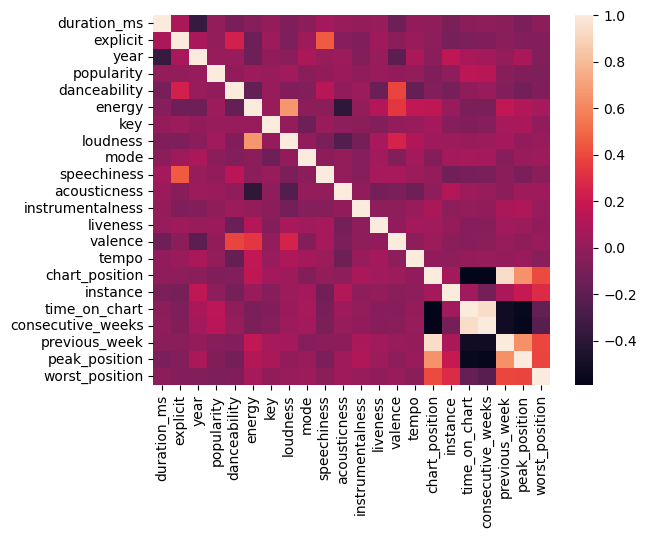

In [18]:
sns.heatmap(df.corr())
plt.show()

In [19]:
df.corr()

,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,chart_position,instance,time_on_chart,consecutive_weeks,previous_week,peak_position,worst_position
duration_ms,1.000000,0.082198,-0.349885,-0.001812,-0.103071,-0.050535,0.006156,-0.075317,-0.030871,0.054649,...,0.010909,-0.138822,-0.011522,-0.013897,-0.088265,-0.029302,-0.019620,-0.041922,-0.096221,-0.027912
explicit,0.082198,1.000000,0.072845,-0.003396,0.242192,-0.139882,0.029688,-0.086104,0.042920,0.452580,...,0.037493,-0.035994,0.020079,-0.019249,-0.106880,-0.085697,-0.068550,-0.040109,-0.067641,-0.057661
year,-0.349885,0.072845,1.000000,0.008304,0.017227,-0.144752,-0.008192,-0.026433,0.080905,0.009937,...,0.009193,-0.209174,0.079231,-0.039135,0.160229,0.085156,0.059402,0.000848,0.084699,-0.065064
popularity,-0.001812,-0.003396,0.008304,1.000000,-0.008312,0.028773,0.017107,0.048744,-0.042902,-0.007871,...,0.019829,-0.008009,-0.005625,-0.075222,-0.021848,0.146407,0.135074,-0.047743,-0.071148,-0.084544
danceability,-0.103071,0.242192,0.017227,-0.008312,1.000000,-0.174928,0.017013,-0.069421,-0.066311,0.136017,...,-0.151310,0.381594,-0.171435,-0.066428,-0.109092,-0.017040,0.008003,-0.060085,-0.113719,-0.072698
energy,-0.050535,-0.139882,-0.144752,0.028773,-0.174928,1.000000,0.018434,0.656894,-0.030382,-0.036000,...,0.120163,0.333444,0.166535,0.157596,0.018689,-0.094491,-0.087341,0.166577,0.108504,0.063569
key,0.006156,0.029688,-0.008192,0.017107,0.017013,0.018434,1.000000,0.006174,-0.138395,0.015199,...,-0.057391,-0.001950,0.012902,0.059765,-0.055475,-0.072714,-0.052615,0.063897,0.084210,-0.008721
loudness,-0.075317,-0.086104,-0.026433,0.048744,-0.069421,0.656894,0.006174,1.000000,-0.007485,-0.089052,...,0.071730,0.253921,0.099009,0.040782,0.028810,0.022962,0.026157,0.057692,-0.006533,0.016467
mode,-0.030871,0.042920,0.080905,-0.042902,-0.066311,-0.030382,-0.138395,-0.007485,1.000000,-0.024766,...,0.044936,-0.066149,0.055756,-0.058823,0.061173,0.068036,0.060442,-0.047650,0.016405,0.029836
speechiness,0.054649,0.452580,0.009937,-0.007871,0.136017,-0.036000,0.015199,-0.089052,-0.024766,1.000000,...,0.067419,0.063607,0.028525,-0.003125,-0.133511,-0.104713,-0.087311,-0.031879,-0.093431,-0.039032


In [20]:
df.shape

(1119, 34)

In [21]:
cat_dummies_list = ['explicit','genre']

rfe, knbest, to select best features target=consecutives

In [22]:
num_columns_list = df.select_dtypes('number').columns

In [23]:
title_dict = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

In [24]:
df['duration_ms'].min(),df['duration_ms'].max()

(113000, 484146)

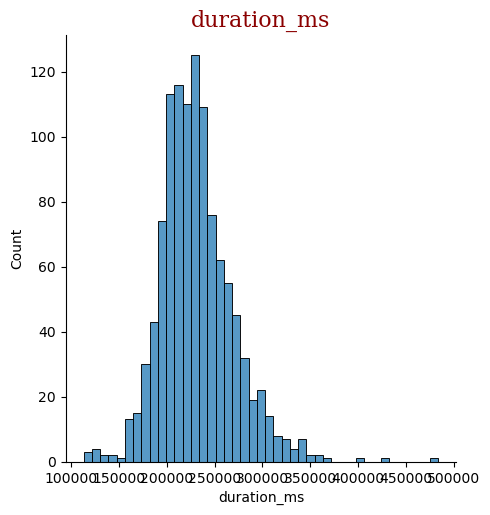

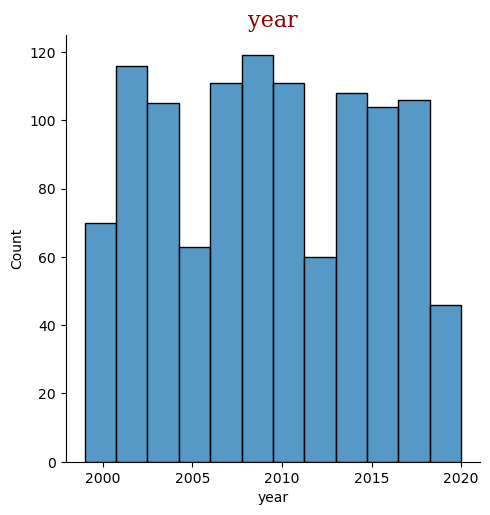

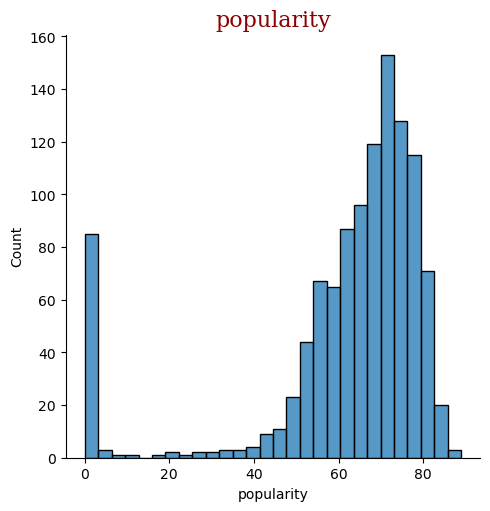

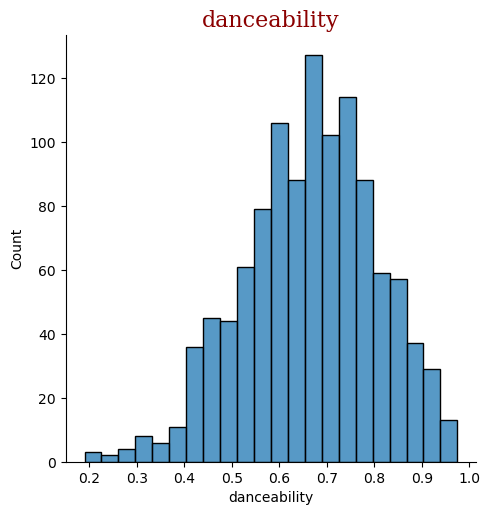

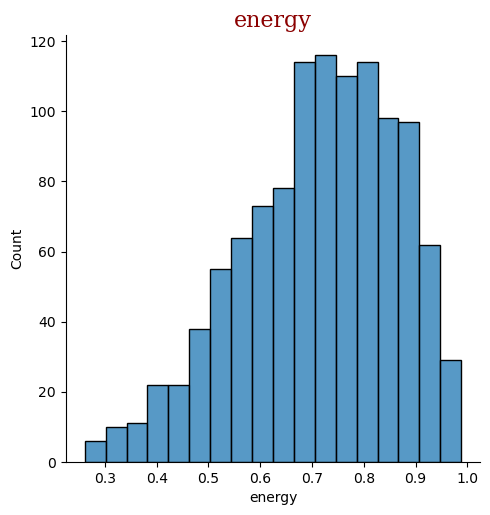

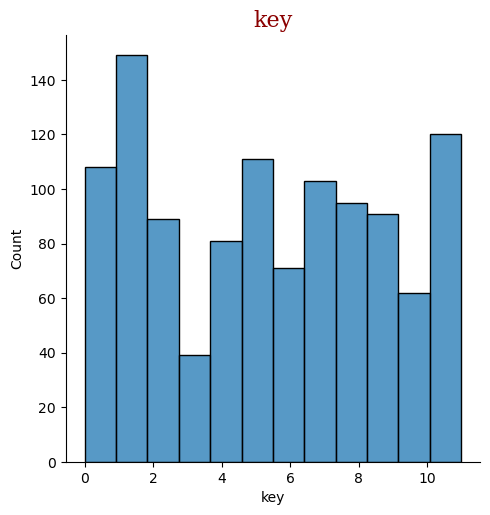

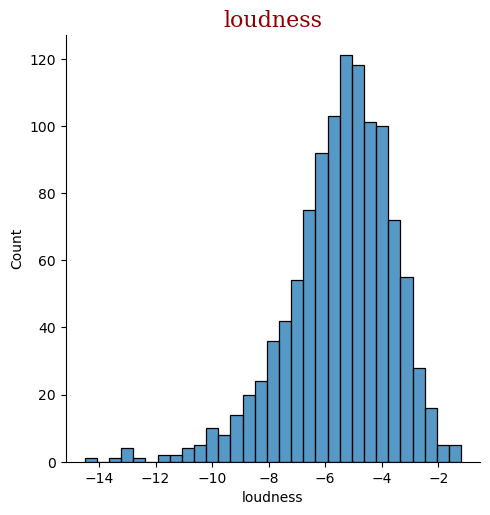

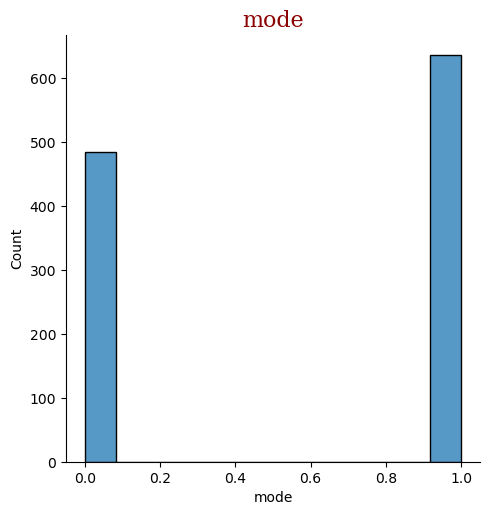

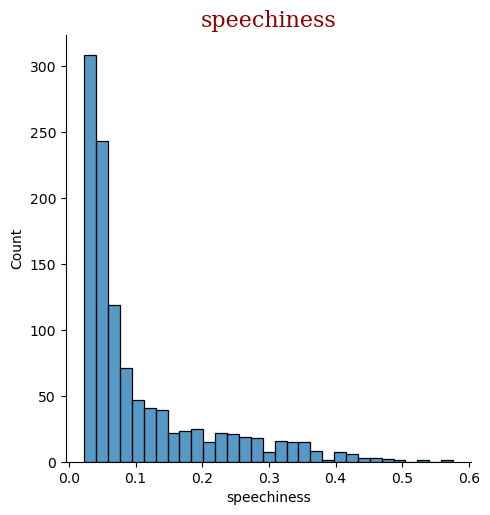

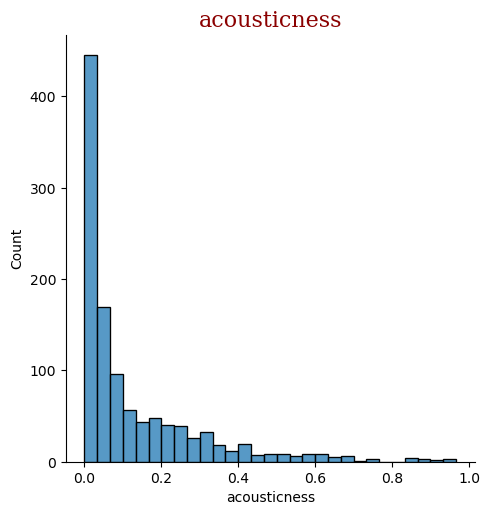

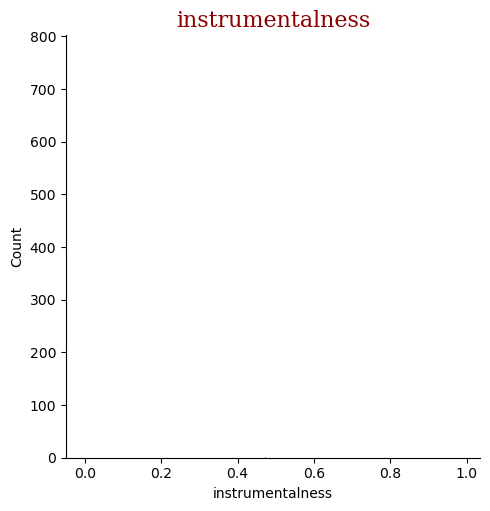

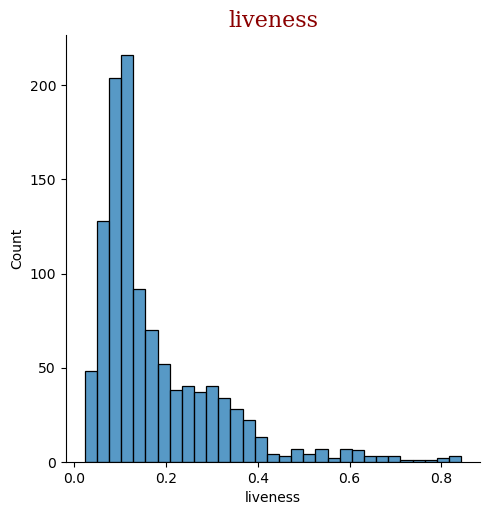

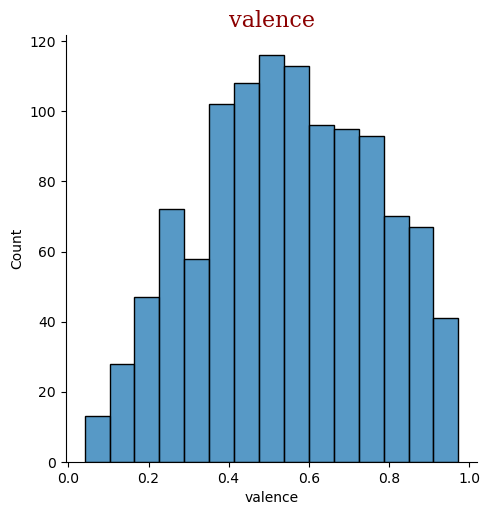

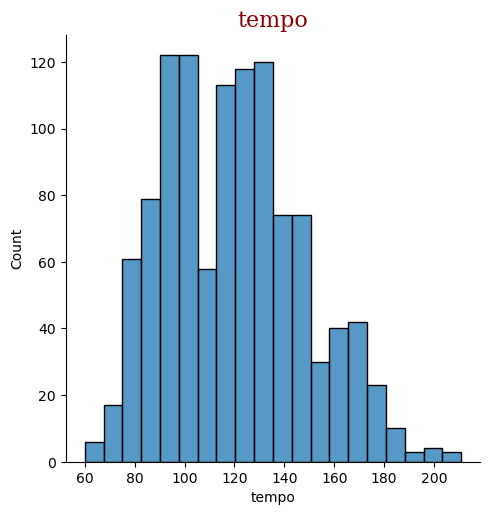

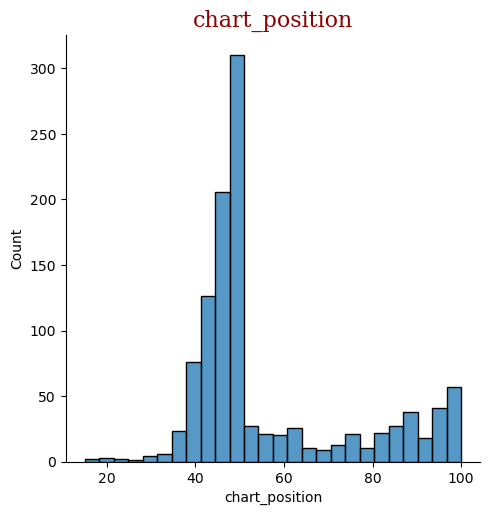

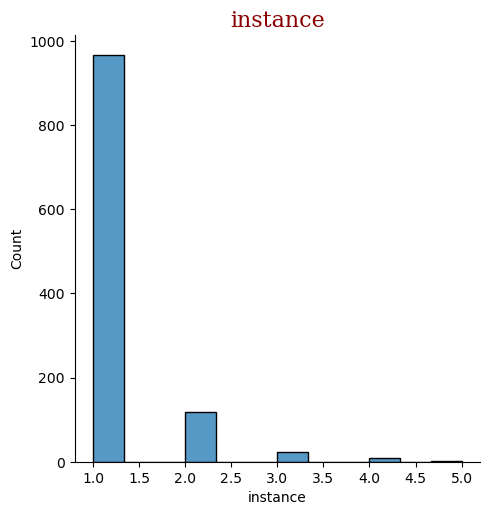

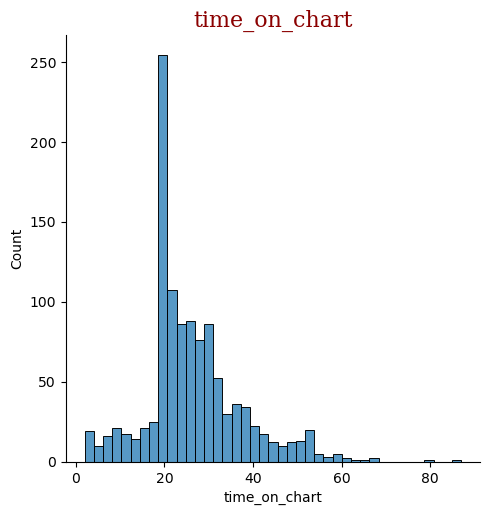

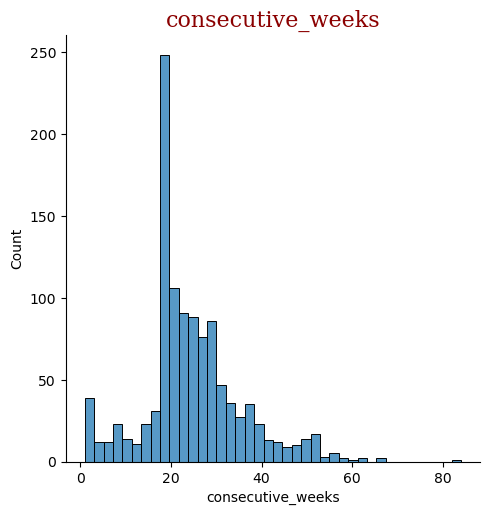

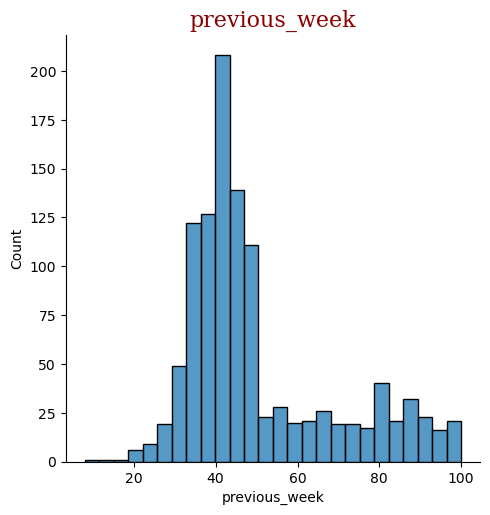

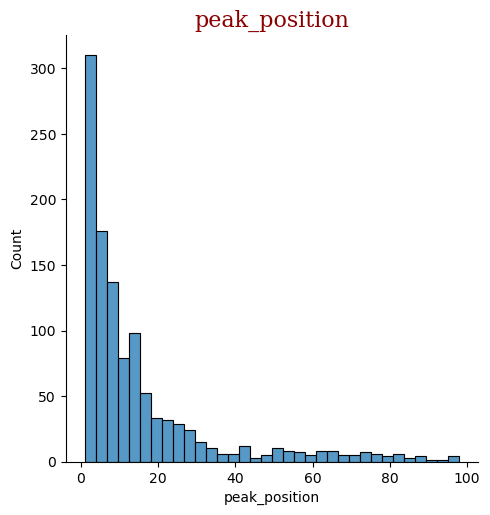

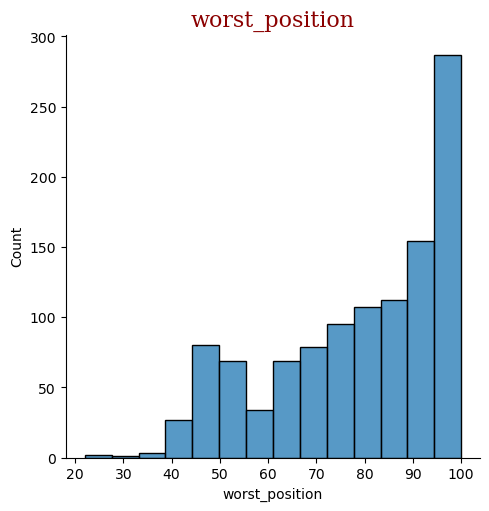

In [25]:
for i in num_columns_list:
    sns.displot(df[i])
    plt.title(i,fontdict=title_dict)
    plt.show()

In [26]:
df.columns

Index(['artist', 'song', 'duration_ms', 'explicit', 'year', 'popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'genre', 'performer_x', 'song_index', 'test_x', 'chart_position',
       'song_y', 'performer_y', 'song_id', 'instance', 'time_on_chart',
       'consecutive_weeks', 'previous_week', 'peak_position', 'worst_position',
       'chart_debut', 'chart_url', 'date'],
      dtype='object')

In [27]:
times_chart_ranks=list(df['time_on_chart'].unique())

In [28]:
len(times_chart_ranks)


63

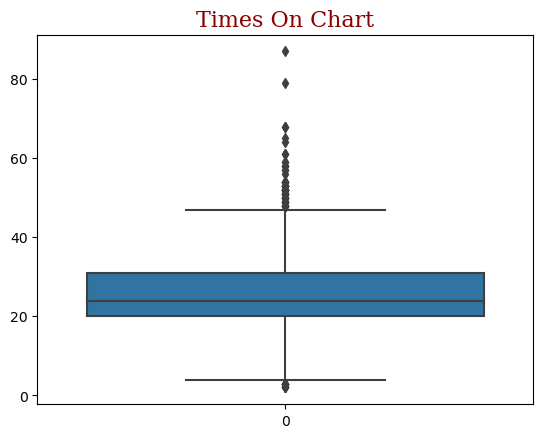

In [29]:
sns.boxplot(df['time_on_chart'])
plt.title("Times On Chart",fontdict=title_dict)
plt.show()

In [30]:
from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 8 features
f_selector = SelectKBest(f_regression, k=8)

# find the top 8 X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()


NameError: name 'X_train_scaled' is not defined

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=2)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
# view list of columns and their ranking

# get the ranks
var_ranks = rfe.ranking_
# get the variable names
var_names = X_train_scaled.columns.tolist()
# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
# sort the df by rank
rfe_ranks_df.sort_values('Rank')


NameError: name 'X_train_scaled' is not defined

In [32]:
df.columns

Index(['artist', 'song', 'duration_ms', 'explicit', 'year', 'popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'genre', 'performer_x', 'song_index', 'test_x', 'chart_position',
       'song_y', 'performer_y', 'song_id', 'instance', 'time_on_chart',
       'consecutive_weeks', 'previous_week', 'peak_position', 'worst_position',
       'chart_debut', 'chart_url', 'date'],
      dtype='object')

In [33]:
target = 'time_on_chart'

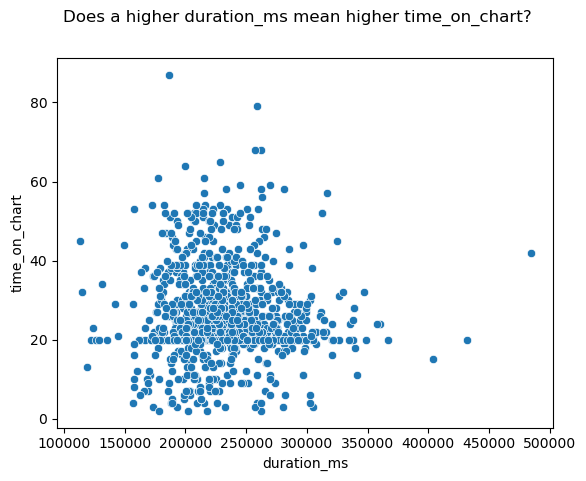

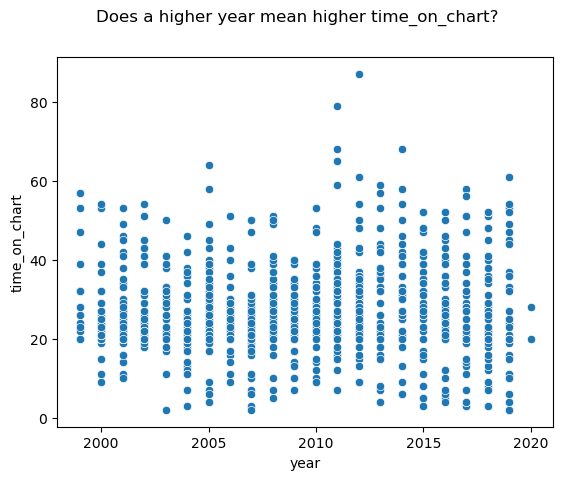

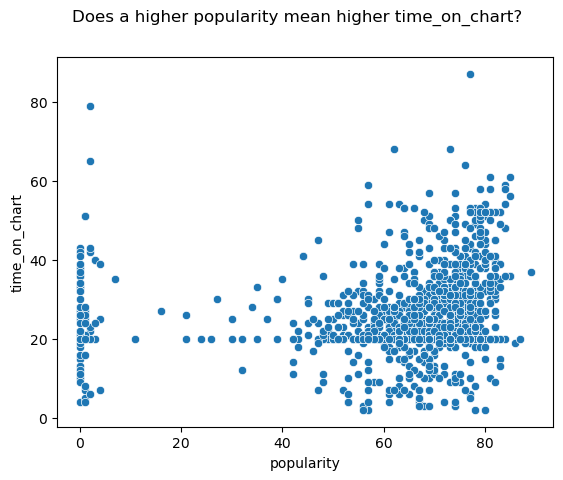

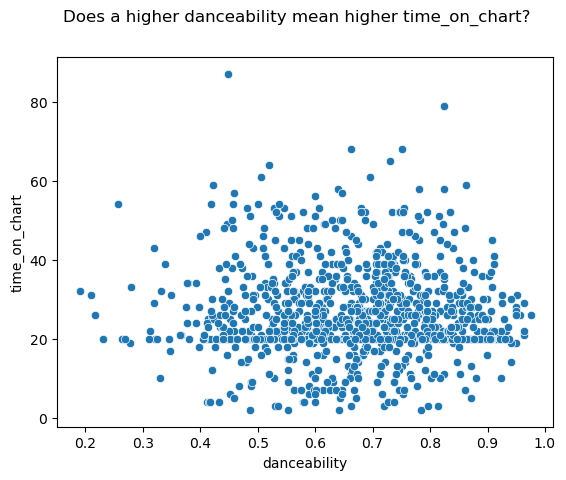

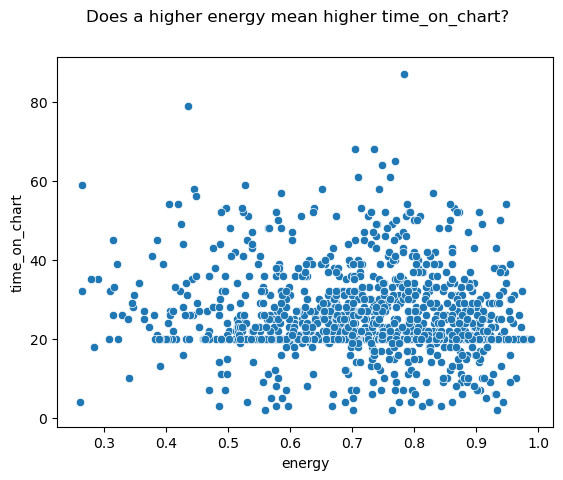

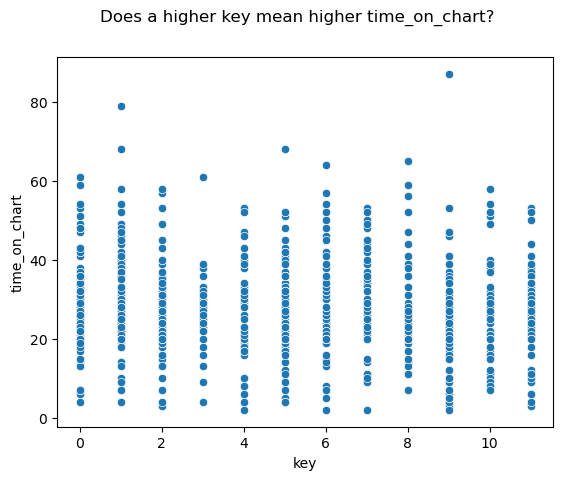

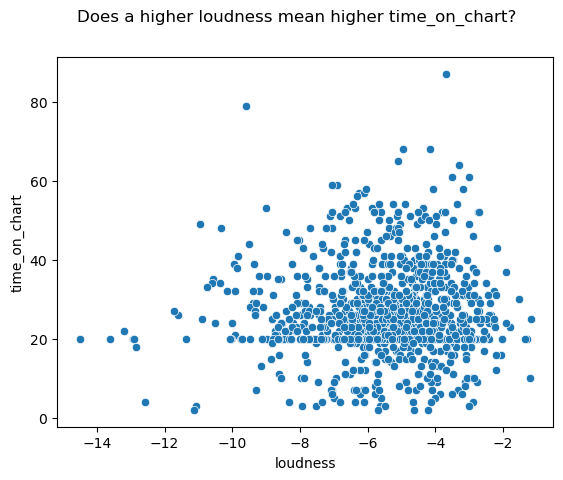

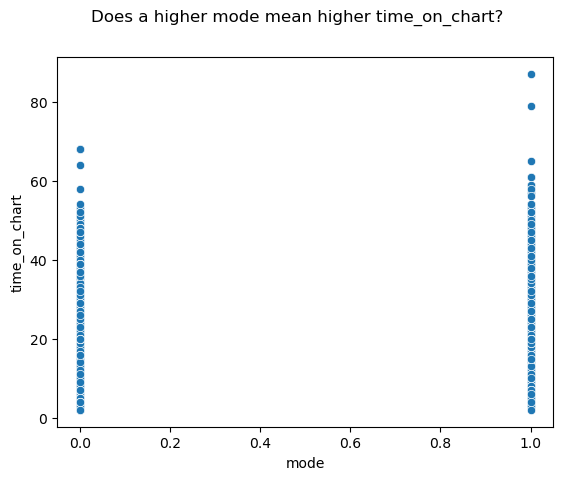

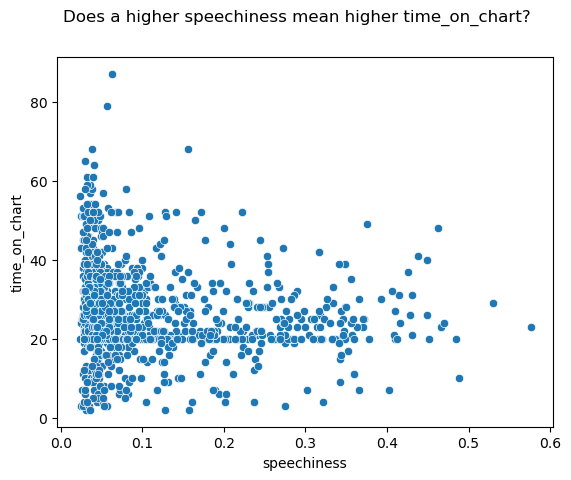

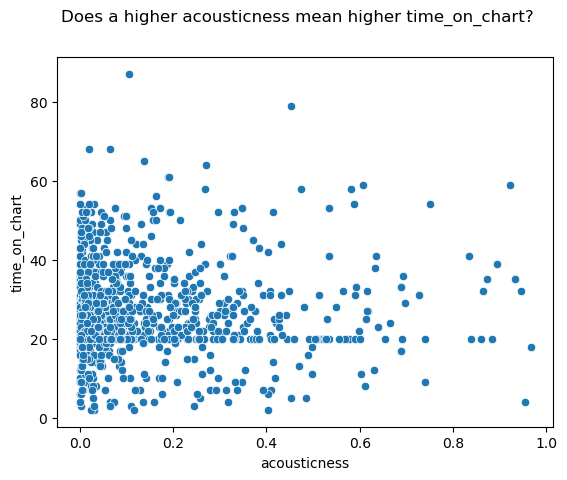

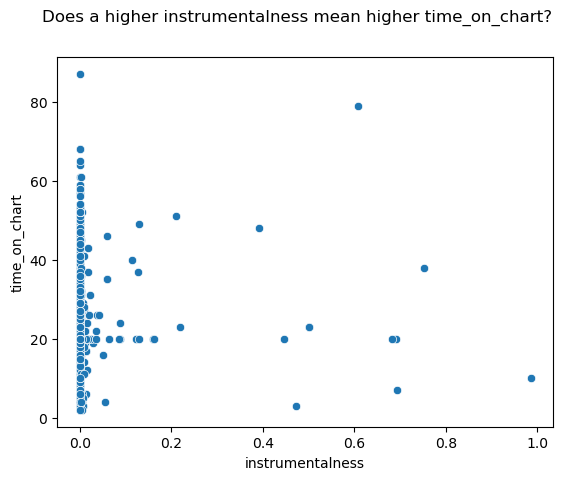

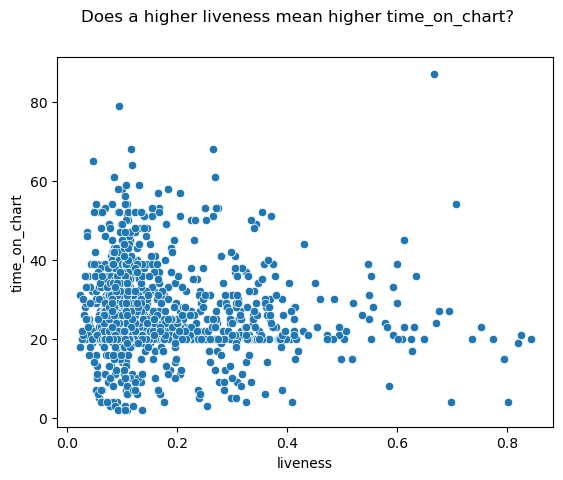

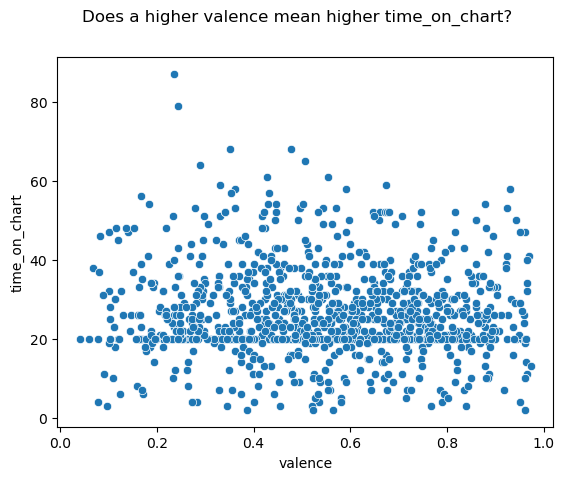

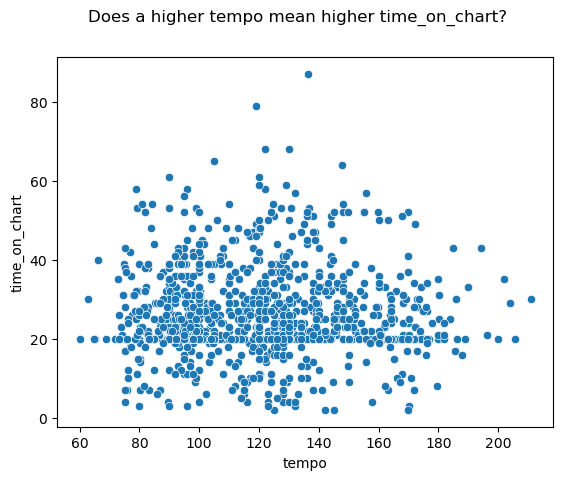

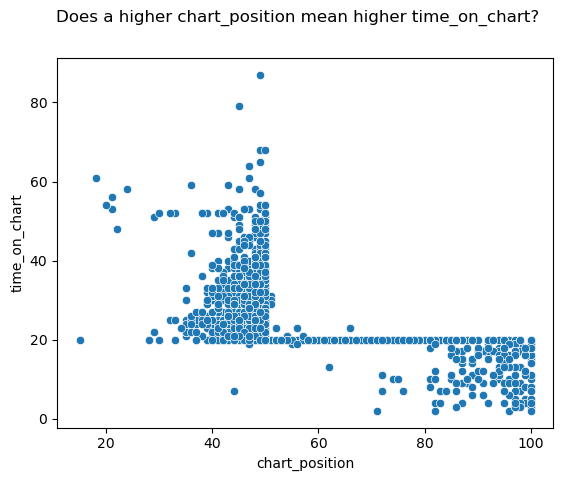

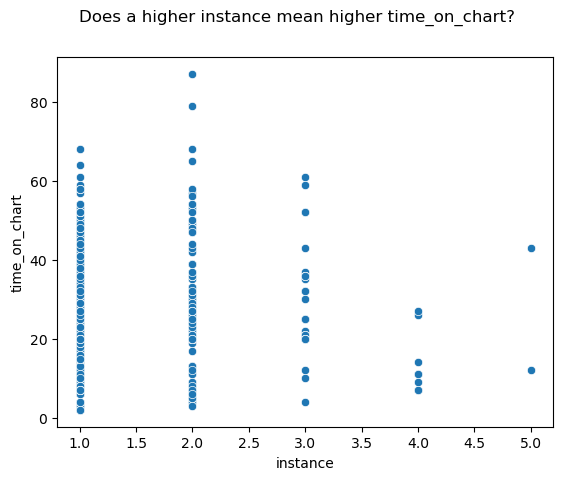

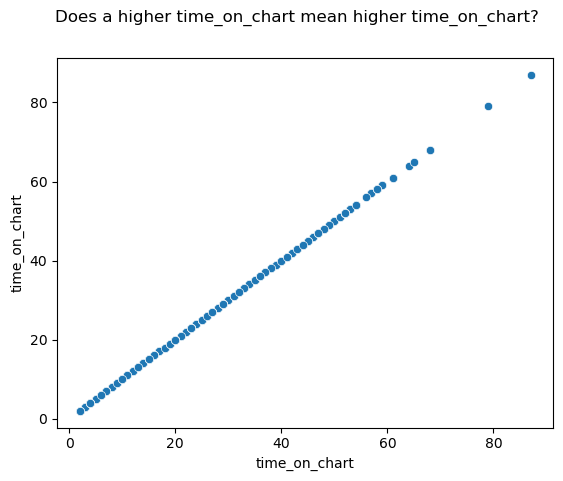

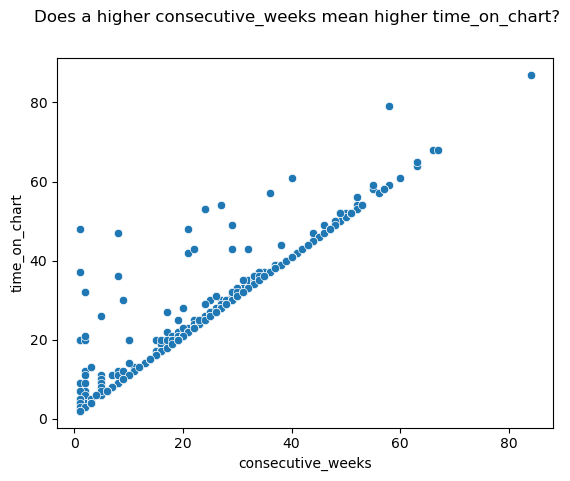

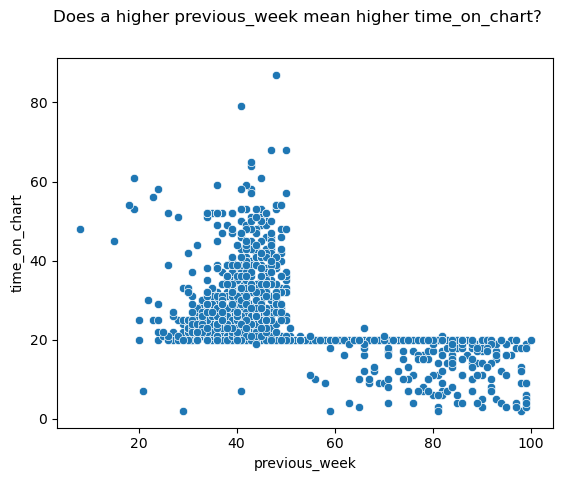

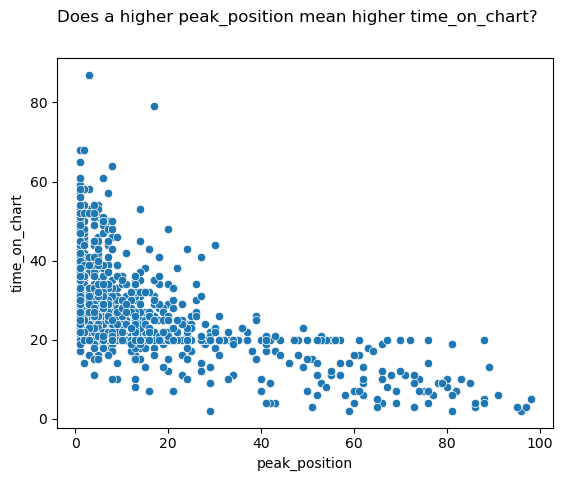

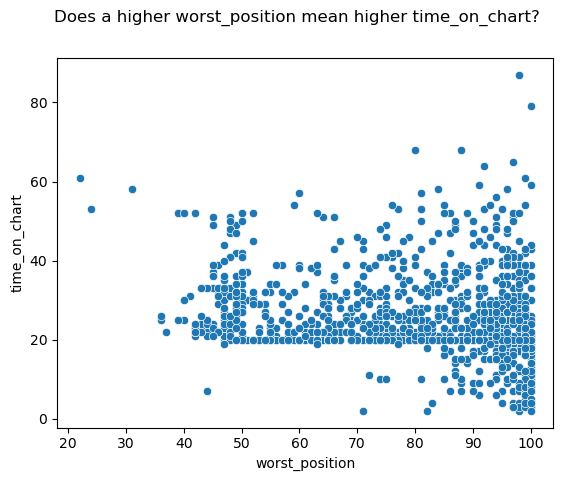

In [35]:
def num_vs_num(df,feature,target):
    question = f"Does a higher {feature} mean higher {target}?"

    sns.scatterplot(x=df[feature], y=df[target])
    plt.suptitle(f"{question}")

    plt.show()

for i in num_columns_list:
    
    num_vs_num(df,i,target)

# Train, Val, Test Split

In [40]:
def separate_column_type_list(df):
    '''
        Creates 2 lists separating continous & discrete
        variables.
        
        Parameters
        ----------
        df : Pandas DataFrame
            The DataFrame from which columns will be sorted.
        
        Returns
        ----------
        continuous_columns : list
            Columns in DataFrame with numerical values.
        discrete_columns : list
            Columns in DataFrame with categorical values.
    '''
    continuous_columns = []
    discrete_columns = []
    
    for column in df.columns:
        if (df[column].dtype == 'int' or df[column].dtype == 'float') and ('id' not in column) and (df[column].nunique()>10):
            continuous_columns.append(column)
        elif(df[column].dtype == 'int' or df[column].dtype == 'float') and (df[column].nunique()>11):
            continuous_columns.append(column)
        else:
            discrete_columns.append(column)
            
    return continuous_columns, discrete_columns

[Definition](#functions) <a id="hypothesis"></a>

In [75]:
question_hypothesis_test_2(1,df,'duration_ms',target)

# Question #1:

# Does a higher duration_ms mean higher time_on_chart?

### Hypothesis:

$H_0$: There is no relationship between `duration_ms` to `time_on_chart`

$H_A$: There is a relationship between `duration_ms` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.029301798086126058`

### Results:

### Failed to Reject $H_0$

There is not a significant relationship between duration_ms and time_on_chart. (p-value: 0.3274)

<hr style="border:2px solid gray">

# Baseline

In [ ]:
r, p = stats.pearsonr(cups_of_coffee, exam_score)